# Tesla Stock Price Prediction, Test Bed
### Second Semester Capstone

This notebook is structured for testing the different parameters and seeing what affect they have on model results. Lessons learned from notebooks like LSTMFeaturePrune, LSTM365AtOnce, etc have all been merged into this one file. It should be able to do lookback and lookforward and stuff like that.

#### Notes:

When testing multi-step prediction with 365 days, a lower percent train was found to produce better results. (70% train versus 80% train). Also got better results when using more recent data. I grabbed a new Tesla stock CSV from Yahoo Finance that now leads up to 12/31/2021. Prior tests with the previous data set yielded results of about 69% error at best

<ins>Current Best Results with 365 Day Multistep Prediction:</ins>
<br>18.88% error
<br><ins>Parameters:</ins>
<br>n_in = 200
<br>n_out = 365
<br>n_predict = 1
<br>percent_train = 0.70
<br>n_epochs = 50
<br>batch_size = 60
<br>n_neurons = 60
<br>dropout = 0.1
<br>learning_rate = 0.001
<br>Start Date = 2019-01-02
<br>Feature List = ['Close','Tesla Trend','Musk Trend','GM Trend','EV Trend','Coronavirus Trend','Month','Day of the Month','Day of the Week','Year']

<ins>Current Best Results with 90 Day Multistep Prediction:</ins>
<br>8.36% error
<br><ins>Parameters:</ins>
<br>n_in = 10
<br>n_out = 90
<br>n_predict = 1
<br>percent_train = 0.70
<br>n_epochs = 100
<br>batch_size = 150
<br>n_neurons = 40
<br>dropout = 0.00
<br>learning_rate = 0.001
<br>Start Date = 2019-01-02
<br>Feature List = [Close, Tesla Trend, GM Trend, EV Trend, Coronavirus Trend, Month, Year]

In [36]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor, ceil
from matplotlib import pyplot
from statistics import mean

# LSTM Application

## Preparing Data

In [37]:
# Loading Preprocessed Data File
df = pd.read_csv("preprocessedGM_MoreRecent.csv", parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)
df = df.loc[(df.index >= '2019-01-01')]

print(df.shape)
df.head(1)

(757, 16)


,Open,High,Low,Close,Adj Close,Volume,Tesla Trend,Musk Trend,GM Trend,EV Trend,Coronavirus Trend,Month,Day of the Month,Day of the Week,Day of the Year,Year
Date,,,,,,,,,,,,,,,,
2019-01-02,32.849998,33.810001,32.41,33.639999,31.893358,7662300.0,37.0,8.7,55.8,34.0,0.0,1,2,2,2,2019


In [38]:
df.drop(df.columns.difference(['Date','Close','Tesla Trend','Musk Trend','GM Trend','EV Trend','Coronavirus Trend','Month','Day of the Month','Day of the Week','Day of the Year','Year']), 1, inplace=True)
df.head(3)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,Close,Tesla Trend,Musk Trend,GM Trend,EV Trend,Coronavirus Trend,Month,Day of the Month,Day of the Week,Day of the Year,Year
Date,,,,,,,,,,,
2019-01-02,33.639999,37.00,8.7,55.80,34.00,0.0,1,2,2,2,2019
2019-01-03,32.250000,32.19,7.1,55.18,17.68,0.0,1,3,3,3,2019
2019-01-04,33.330002,28.86,9.7,55.18,22.44,0.0,1,4,4,4,2019


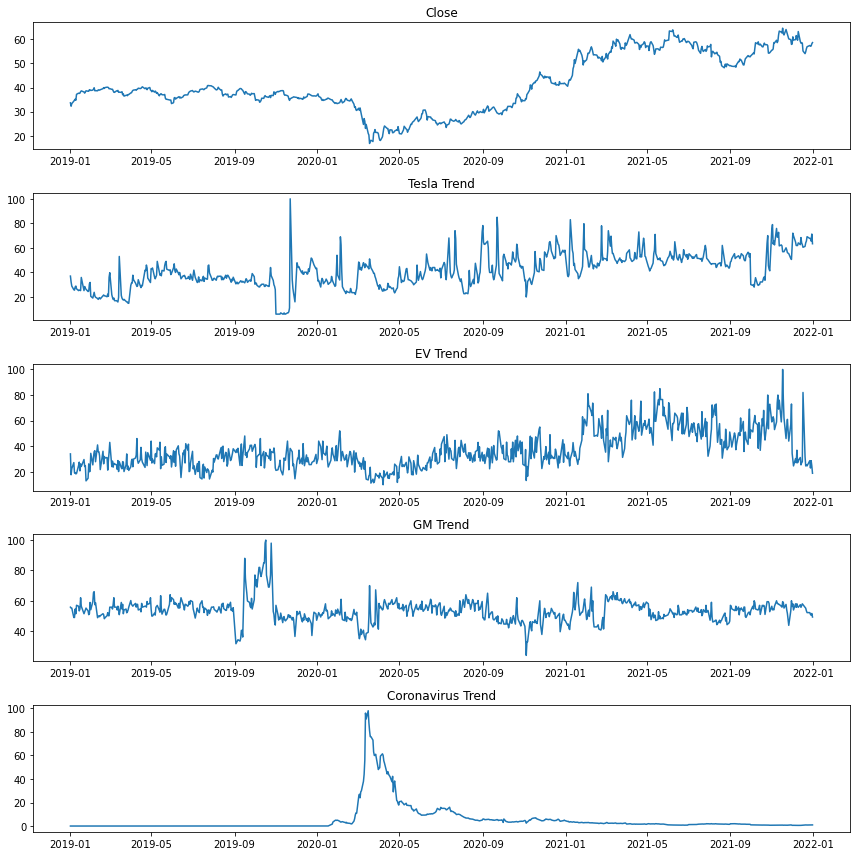

In [39]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(12,12))
pyplot.subplot(5, 1, 1)
pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")
pyplot.subplot(5, 1, 2)
pyplot.plot(dates, df["Tesla Trend"], label="Tesla Trend")
pyplot.title("Tesla Trend")
pyplot.subplot(5, 1, 3)
pyplot.plot(dates, df["EV Trend"], label="EV Trend")
pyplot.title("EV Trend")
pyplot.subplot(5, 1, 4)
pyplot.plot(dates, df["GM Trend"], label="GM Trend")
pyplot.title("GM Trend")
pyplot.subplot(5, 1, 5)
pyplot.plot(dates, df["Coronavirus Trend"], label="Coronavirus Trend")
pyplot.title("Coronavirus Trend")
pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [40]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Conversion of Time Series Data

In [41]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features, makes it easier for the model to train on
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [42]:
n_in = 200                # timesteps for input           
n_out = 365            # timesteps for output
n_predict = 1          # n_predict = (number of data points you want to predict) / n_out
percent_train = 0.70    # percent as decimal

# frame as supervised learning
reframed = series_to_supervised(scaled, df.columns, n_in, n_out)
# Drop Columns of Variables We Aren't Predicting
for i in range(1, n_out):
    reframed.drop(reframed.loc[:, ('Tesla Trend(t+%i)' %(i)):('Year(t+%i)' %(i))], axis=1, inplace=True)
reframed.drop(reframed.loc[:, 'Tesla Trend(t)':'Year(t)'], axis=1, inplace=True)
print(reframed.shape)
reframed.head()

(193, 2565)


,Close(t-200),Tesla Trend(t-200),Musk Trend(t-200),GM Trend(t-200),EV Trend(t-200),Coronavirus Trend(t-200),Month(t-200),Day of the Month(t-200),Day of the Week(t-200),Day of the Year(t-200),...,Close(t+355),Close(t+356),Close(t+357),Close(t+358),Close(t+359),Close(t+360),Close(t+361),Close(t+362),Close(t+363),Close(t+364)
200,0.352228,0.329787,0.069602,0.418421,0.267643,0.0,0.0,0.033333,0.50,0.000000,...,0.904622,0.888308,0.899812,0.863836,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412
201,0.323154,0.278617,0.053297,0.410263,0.086551,0.0,0.0,0.066667,0.75,0.002747,...,0.888308,0.899812,0.863836,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412,0.850450
202,0.345744,0.243191,0.079792,0.410263,0.139370,0.0,0.0,0.100000,1.00,0.005495,...,0.899812,0.863836,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412,0.850450,0.857561
203,0.367287,0.211702,0.064506,0.328684,0.192188,0.0,0.0,0.200000,0.00,0.013736,...,0.863836,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412,0.850450,0.857561,0.925329
204,0.376699,0.207766,0.051259,0.328684,0.101642,0.0,0.0,0.233333,0.25,0.016484,...,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412,0.850450,0.857561,0.925329,0.944154


In [43]:
y_vals = reframed.iloc[:,n_out*-1:].values
x_vals = reframed.iloc[:,:n_out*-1].values
# split into train, test, and prediction sets
n_train = floor((len(x_vals)-n_predict) * percent_train)

# split into input and outputs
train_X, train_y = x_vals[:n_train, :], y_vals[:n_train, :]
test_X, test_y = x_vals[n_train:len(x_vals)-n_predict, :], y_vals[n_train:len(y_vals)-n_predict, :]
predict_X, predict_y = x_vals[len(x_vals)-n_predict:, :], y_vals[len(y_vals)-n_predict:, :]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((n_train, n_in, len(df.columns)))
test_X = test_X.reshape((test_X.shape[0], n_in, len(df.columns)))
predict_X = predict_X.reshape((n_predict, n_in, len(df.columns)))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(134, 200, 11) (134, 365) (58, 200, 11) (58, 365) (1, 200, 11) (1, 365)


## Running Model

### Function For Running Model

In [44]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [45]:
# Design Network
def fit_lstm(train_X, train_y, test_X, test_y, n_out, batch_size, n_epochs, n_neurons, dropout=0.0, lr=0.001, v=0):

    model = Sequential()
    model.add(LSTM(n_neurons, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))
    model.add(Dense(n_out, activation="linear", kernel_constraint=NonNeg()))

    opt = Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer=opt, metrics=['accuracy'])

    # fit network
    history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=v, shuffle=False)

    # Return model, model training history, and prediction
    return model, history

### Testing Loop

Neurons = 40
Trial 1 Normalized RMSE: 0.2206 | Trial 2 Normalized RMSE: 0.2088 | Trial 3 Normalized RMSE: 0.2006 | Trial 4 Normalized RMSE: 0.2030 | Trial 5 Normalized RMSE: 0.2326 | Trial 6 Normalized RMSE: 0.2054 | Trial 7 Normalized RMSE: 0.2109 | 


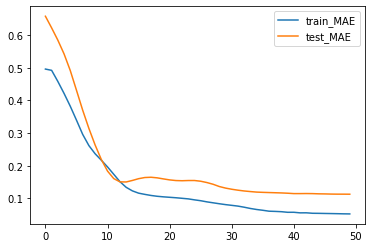

Best NRMSE: 0.2006

Neurons = 60
Trial 1 Normalized RMSE: 0.1943 | Trial 2 Normalized RMSE: 0.2253 | Trial 3 Normalized RMSE: 0.2218 | Trial 4 Normalized RMSE: 0.2234 | Trial 5 Normalized RMSE: 0.1831 | Trial 6 Normalized RMSE: 0.2325 | Trial 7 Normalized RMSE: 0.2195 | 


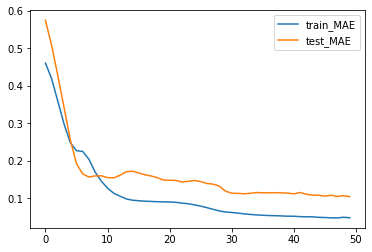

Best NRMSE: 0.1831

Neurons = 100
Trial 1 Normalized RMSE: 0.2025 | Trial 2 Normalized RMSE: 0.2012 | Trial 3 Normalized RMSE: 0.2297 | Trial 4 Normalized RMSE: 0.2045 | Trial 5 Normalized RMSE: 0.2001 | Trial 6 Normalized RMSE: 0.2088 | Trial 7 Normalized RMSE: 0.1971 | 


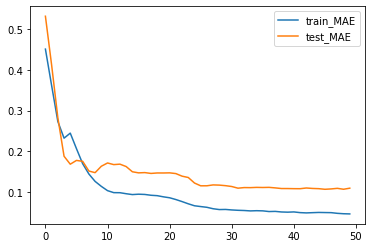

Best NRMSE: 0.1971

Neurons = 150
Trial 1 Normalized RMSE: 0.2154 | Trial 2 Normalized RMSE: 0.2191 | Trial 3 Normalized RMSE: 0.2240 | Trial 4 Normalized RMSE: 0.2105 | Trial 5 Normalized RMSE: 0.2080 | Trial 6 Normalized RMSE: 0.1934 | Trial 7 Normalized RMSE: 0.2033 | 


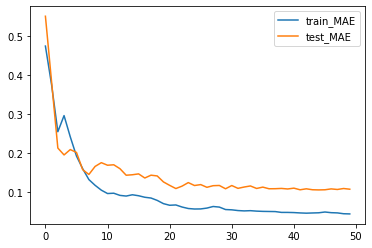

Best NRMSE: 0.1934



In [46]:
from sklearn.metrics import mean_squared_error

# Adjustable Hyperparameters
n_trials = 7
n_epochs = 50
batch_size = 60
n_neurons = 60
dropout = 0.1                                      # default is 0.0
learning_rate = 0.001                               # default is 0.001
testingArray = [40, 60, 100, 150]
verbose = 0                                         # 0, 1, or 2
thingTested = "Neurons"                       # just for output purposes

# Results Dictionary
results = {}
results["best_nrmse"] = {}
results["best_history"] = {}
results["best_invy"] = {}
results["best_invyhat"] = {}
results["best_model"] = {}
scaler.fit(df["Close"].values.reshape(-1,1))
inv_y = scaler.inverse_transform(predict_y).reshape(n_out*n_predict)

for testingThing in testingArray:
    print("%s = %s" %(thingTested, testingThing))
    for r in range(n_trials):
        print("Trial %i " %(r+1), end="")
        model, history = fit_lstm(
            train_X, train_y, test_X, test_y, n_out, # Move testingThing to whatever parameter you're testing
            batch_size=batch_size,                
            n_epochs=n_epochs,
            n_neurons=testingThing,
            dropout=dropout,
            lr=learning_rate,
            v=verbose
        )
        # Make Prediction
        yhat = model.predict(predict_X)
        inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1)).reshape(n_out*n_predict)
        # calculate RMSE and NRMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        normalized_rmse = rmse/(mean(inv_y))
        print('Normalized RMSE: %.4f | ' % normalized_rmse, end="")
        # Store the model with the best NRMSE
        if testingThing not in results["best_nrmse"] or normalized_rmse < results["best_nrmse"][testingThing]:
            results["best_nrmse"][testingThing] = normalized_rmse
            results["best_history"][testingThing] = history
            results["best_invyhat"][testingThing] = inv_yhat
            results["best_model"][testingThing] = model
            if "overall_best" not in results["best_nrmse"] or normalized_rmse < results["best_nrmse"]["overall_best"]:
                results["best_nrmse"]["overall_best"] = normalized_rmse
                results["best_history"]["overall_best"] = history
                results["best_invyhat"]["overall_best"] = inv_yhat
                results["best_model"]["overall_best"] = model
    print()
    pyplot.figure()
    pyplot.plot(results["best_history"][testingThing].history['loss'], label='train_MAE')
    pyplot.plot(results["best_history"][testingThing].history['val_loss'], label='test_MAE')
    pyplot.legend()
    pyplot.show()
    print("Best NRMSE: %.4f\n" %(results["best_nrmse"][testingThing]))

## Results

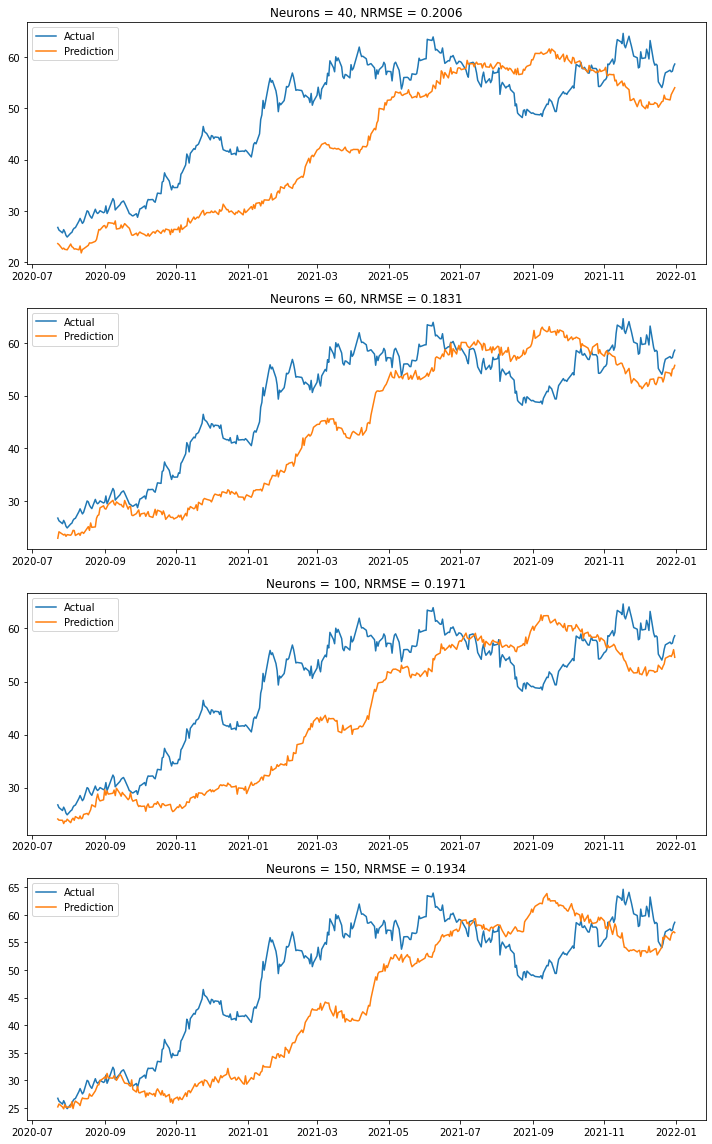

In [47]:
predictDates = dates[len(dates)-(n_out*n_predict):]
pyplot.figure(figsize=(10,4*len(testingArray)))
i = 1
for testingThing in testingArray:
    
    inv_yhat = results["best_invyhat"][testingThing]

    pyplot.subplot(len(testingArray), 1, i)
    pyplot.plot(predictDates, inv_y, label="Actual")
    pyplot.plot(predictDates, inv_yhat, label="Prediction")
    pyplot.legend(loc='upper left')
    pyplot.title("%s = %s, NRMSE = %.4f" %(thingTested, testingThing, results["best_nrmse"][testingThing]))

    i+= 1

pyplot.tight_layout()
pyplot.show()
    

In [48]:
inv_yhat = results["best_invyhat"]["overall_best"]
numQuarters = floor(n_out / 91)
quarter = floor(n_out/numQuarters)
print(quarter)
maxes = [predictDates[np.argmax(inv_yhat[0:quarter], axis=0)]]
maxes_actual = [predictDates[np.argmax(inv_y[0:quarter], axis=0)]]
for i in range(0, numQuarters-1):
    maxes.append(predictDates[np.argmax(inv_yhat[quarter*(i+1):quarter*(i+2)-1], axis=0)+quarter*(i+1)])
    maxes_actual.append(predictDates[np.argmax(inv_y[quarter*(i+1):quarter*(i+2)-1], axis=0)+quarter*(i+1)])
    

91


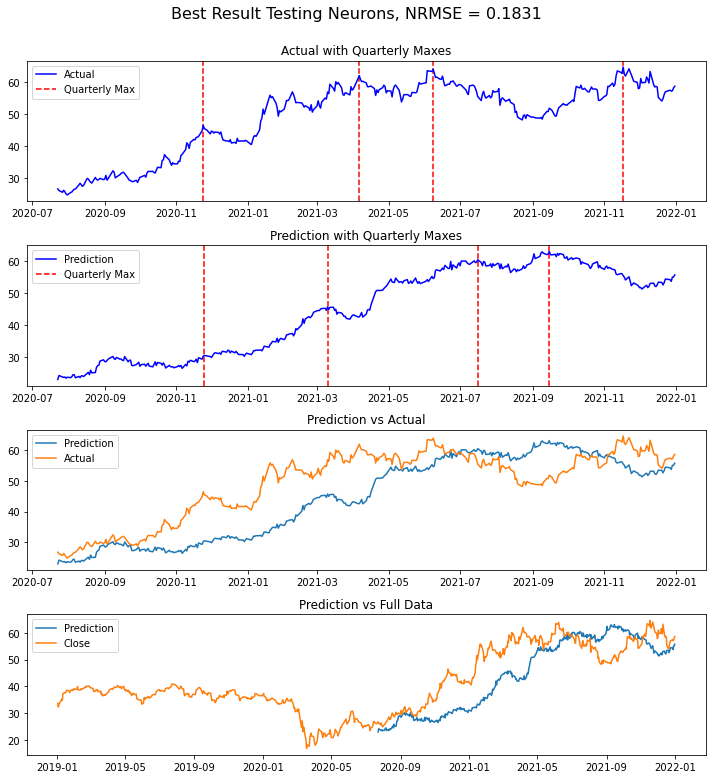

In [49]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(10,11))

pyplot.suptitle("Best Result Testing %s, NRMSE = %.4f\n" %(thingTested, results["best_nrmse"]["overall_best"]), fontsize=16)
pyplot.subplot(4, 1, 1)
pyplot.plot(predictDates, inv_y, color='b', label="Actual", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Actual with Quarterly Maxes")

pyplot.subplot(4, 1, 2)
pyplot.plot(predictDates, inv_yhat, color='b', label="Prediction", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Prediction with Quarterly Maxes")

pyplot.subplot(4,1,3)
pyplot.plot(predictDates, inv_yhat, label="Prediction")
pyplot.plot(predictDates, inv_y, label="Actual")
pyplot.legend(loc='upper left')
pyplot.title("Prediction vs Actual")

pyplot.subplot(4,1,4)
pyplot.plot(predictDates, inv_yhat, label="Prediction")
pyplot.plot(dates, df["Close"], label="Close")
pyplot.legend(loc='upper left')
pyplot.title("Prediction vs Full Data")

pyplot.tight_layout()
pyplot.show()

In [50]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i]))
    print("Diff: %s" %abs((maxes_actual[i]-maxes[i]).astype('timedelta64[D]')))

Q1 Max: 2020-11-25T00:00:00.000000000
Q1 Actual Max: 2020-11-24T00:00:00.000000000
Diff: 1 days
Q2 Max: 2021-03-10T00:00:00.000000000
Q2 Actual Max: 2021-04-06T00:00:00.000000000
Diff: 27 days
Q3 Max: 2021-07-16T00:00:00.000000000
Q3 Actual Max: 2021-06-08T00:00:00.000000000
Diff: 38 days
Q4 Max: 2021-09-15T00:00:00.000000000
Q4 Actual Max: 2021-11-17T00:00:00.000000000
Diff: 63 days


In [52]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(results["best_model"]["overall_best"], train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
shap_values_2D = shap_values[0].reshape(-1,len(df.columns)*n_in)
predict_X_2D = predict_X.reshape(-1,len(df.columns)*n_in)

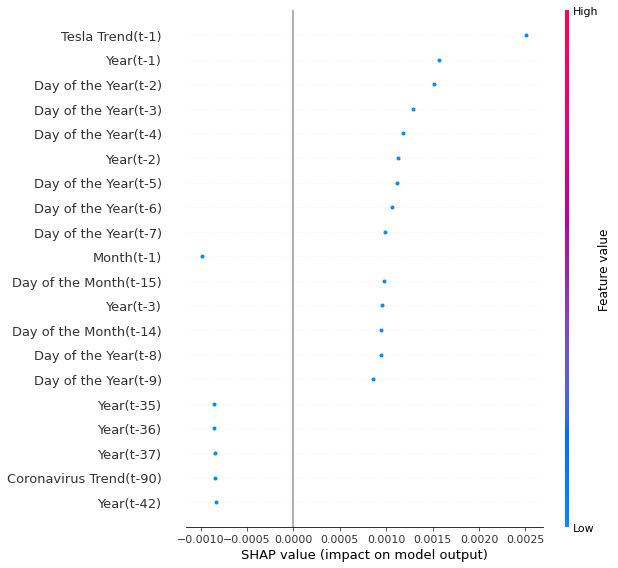

In [53]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=reframed.columns[:len(df.columns)*n_in])